In [78]:
#这次对小数据集进行词级别的机器翻译
import torch
import torch.utils.data as da
import torch.nn as nn
import torch.optim as optim
import jieba
import argparse
import matplotlib.pyplot as plt
from collections import Counter
import random
import time
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import matplotlib    
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"/home/renhongjie/miniconda3/envs/rencaiji/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Songti.ttc", size=14)

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
parser = argparse.ArgumentParser()

parser.add_argument('--en_path', type=str, default='data/news-commentary-v13.zh-en.en',
                   help='英文数据集路径')
parser.add_argument('--zh_path', type=str, default='data/news-commentary-v13.zh-en.zh',
                   help='中文数据集路径')
parser.add_argument('--seq_len', type=int, default=60,
                   help='句子最大的长度，多则截断，少则补<unk>')
parser.add_argument('--pad', type=str, default='<unk>',
                   help='填充词')
parser.add_argument('--batch_size',type=int,default=512,
                   help='每轮批次')
parser.add_argument('--en_embedding_dim',type=int,default=256,
                   help='编码器词向量的长度')
parser.add_argument('--en_hidden_dim',type=int,default=512,
                   help='编码器深度')
parser.add_argument('--en_n_layers',type=int,default=2,
                   help='编码器LSTM的层数')
parser.add_argument('--de_embedding_dim',type=int,default=256,
                   help='解码器词向量的长度')
parser.add_argument('--de_hidden_dim',type=int,default=512,
                   help='解码器深度')
parser.add_argument('--de_n_layers',type=int,default=2,
                   help='解码器LSTM的层数')
parser.add_argument('--dropout',type=int,default=0.5,
                   help='droput')
parser.add_argument('--lr',type=int,default=0.0001,
                   help='学习率')
parser.add_argument('--weight_decay',type=int,default=0.1,
                   help='权重衰减/L2范式')
parser.add_argument('--clip',type=int,default=1,
                   help='梯度剪切')
parser.add_argument('--epochs',type=int,default=200,
                   help='训练轮数')
parser.add_argument('--attn_method',type=str,default='general',
                   help='启用注意力机制')

#kwargs = parser.parse_args()
kwargs = parser.parse_known_args()[0]


In [5]:
# with open(kwargs.en_path, 'r') as f_en:
#     data_en = f_en.readlines()
# with open(kwargs.zh_path, 'r') as f_zh:
#     data_zh = f_zh.readlines()

In [6]:
#用一个小数据集合先玩玩
with open('./cmn-eng/cmn.txt', 'r', encoding='utf-8') as f:
    data = f.read()
data = data.strip()
data = data.split('\n')
# 分割英文数据和中文数据
data_en = [line.split('\t')[0] for line in data]
data_zh = [line.split('\t')[1] for line in data]

In [7]:
#特殊处理
def data_process(text):
    text = text.lower()
    # 特殊数据处理，该地方可以各种替换缩略词等
    # 去除标点等
    return text

In [8]:
#对单句话进行分词
def get_token_text(text_en,text_zh):
    #简单的句子处理
    text_en=text_en.replace('.',' .').replace('?',' ?').replace('!',' !').replace(',',' , ')
    text_zh=text_zh.strip('\n')
    #英文以空格分割
    token_data_en = [data_process(st) for st in text_en.split()]
    #中文一般用jieba
    token_data_zh = [data_process(st) for st in jieba.cut(text_zh)]
    return [token_data_en,token_data_zh]

In [9]:
#对两个数据集的每句话进行分词
def get_token_data(data_en,data_zh):
    data_token_en = []
    data_token_zh = []
    for en,zh in zip(data_en,data_zh):
        en,zh=get_token_text(en,zh)
        data_token_en.append(en)
        data_token_zh.append(zh)
    return data_token_en,data_token_zh

In [10]:
def get_vocab(data):
    data=[j for i in data for j in i]
    top_1000 = Counter(data).most_common(100000)
    vocab = {x[0]:x[1] for x in top_1000}
    word_to_idx = {word: i + 4 for i, word in enumerate(vocab)}
    word_to_idx['<pad>'] = 0
    word_to_idx['<sos>'] = 1
    word_to_idx['<eos>'] = 2
    word_to_idx['<unk>'] = 3
    idx_to_word = {i + 4: word for i, word in enumerate(vocab)}
    idx_to_word[0] = '<pad>'
    idx_to_word[1] = '<sos>'
    idx_to_word[2] = '<eos>'
    idx_to_word[3] = '<unk>'
    vocab_size=len(idx_to_word)
    return vocab, vocab_size, word_to_idx, idx_to_word

In [11]:
# 填充和截断
def pad_st(features, maxlen, pad=0):
    padded_features = []
    for feature in features:
        feature.insert(0,'<sos>')
        feature.append('<eos>')
        if len(feature) > maxlen:
            padded_feature = feature[:maxlen]
            padded_feature[-1]='<eos>'#防止<eos>被切掉
        else:
            padded_feature = feature
            while (len(padded_feature) < maxlen):
                padded_feature.append(pad)
        padded_features.append(padded_feature)
    return padded_features

In [12]:
# 转化为索引
def encode_st(token_data, word_to_idx):
    features = []
    for sample in token_data:
        feature = []
        feature.append(1)
        for token in sample:
            if token in word_to_idx:
                feature.append(word_to_idx[token])
            else:#如果是词库中不存在的，认为是<unk>，即0
                feature.append(0)
        feature.append(2)
        features.append(feature)
    
    return features

In [13]:
#此时为二维数组，每个数组是之前每句话的分词结果，词级别
en_data,zh_data=get_token_data(data_en,data_zh)


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Dump cache file failed.
Traceback (most recent call last):
  File "/home/renhongjie/miniconda3/envs/rencaiji/lib/python3.6/site-packages/jieba/__init__.py", line 154, in initialize
    _replace_file(fpath, cache_file)
PermissionError: [Errno 1] Operation not permitted: '/tmp/tmpflcj0qpl' -> '/tmp/jieba.cache'
Loading model cost 0.826 seconds.
Prefix dict has been built successfully.


In [14]:
print(en_data[0:2],zh_data[0:2])

[['hi', '.'], ['hi', '.']] [['嗨', '。'], ['你好', '。']]


In [15]:
vocab_en,vocab_size_en, word_to_idx_en, idx_to_word_en=get_vocab(en_data)
vocab_zh,vocab_size_zh, word_to_idx_zh, idx_to_word_zh=get_vocab(zh_data)


In [16]:
kwargs.vocab_size_en=vocab_size_en#记录vocab大小
kwargs.vocab_size_zh=vocab_size_zh#记录vocab大小
print(vocab_size_en,vocab_size_zh)

6904 14719


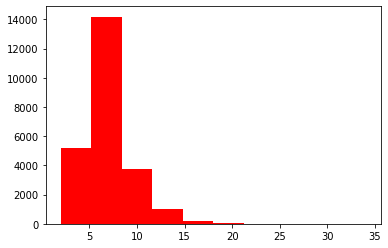

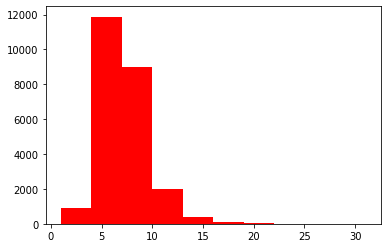

In [17]:
#看一下预料的长度分布，然后选择一个合适的seq_len
en_data_length=[]
for i in en_data:
    en_data_length.append(len(i))
n, bins, patches = plt.hist(en_data_length, bins=10, edgecolor='None',facecolor='red') 
plt.show()
zh_data_length=[]
for i in zh_data:
    zh_data_length.append(len(i))
n, bins, patches = plt.hist(zh_data_length, bins=10, edgecolor='None',facecolor='red') 
plt.show()

In [18]:
print(zh_data_length[0:10])

[2, 2, 5, 2, 3, 2, 2, 4, 3, 2]


In [19]:
en_data_id=encode_st((en_data),word_to_idx_en)
zh_data_id=encode_st((zh_data),word_to_idx_zh)

In [20]:
print(en_data_id[0:3])

[[1, 1766, 4, 2], [1, 1766, 4, 2], [1, 534, 4, 2]]


In [21]:
from torch.utils.data import Dataset, DataLoader
class TranslationDataset(Dataset):
    def __init__(self, src_data, trg_data):
        self.src_data = src_data
        self.trg_data = trg_data

        assert len(src_data) == len(trg_data), \
            "numbers of src_data  and trg_data must be equal!"

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        src_sample =self.src_data[idx]
        src_len = len(self.src_data[idx])
        trg_sample = self.trg_data[idx]
        trg_len = len(self.trg_data[idx])
        return {"src": src_sample, "src_len": src_len, "trg": trg_sample, "trg_len": trg_len}

In [22]:
def padding_batch(batch):
    """
    input: -> list of dict
        [{'src': [1, 2, 3], 'trg': [1, 2, 3]}, {'src': [1, 2, 2, 3], 'trg': [1, 2, 2, 3]}]
    output: -> dict of tensor 
        {
            "src": [[1, 2, 3, 0], [1, 2, 2, 3]].T
            "trg": [[1, 2, 3, 0], [1, 2, 2, 3]].T
        }
    """
    src_lens = [d["src_len"] for d in batch]
    trg_lens = [d["trg_len"] for d in batch]
    
    src_max = max([d["src_len"] for d in batch])
    trg_max = max([d["trg_len"] for d in batch])
    for d in batch:
        word_to_idx_en
        d["src"].extend([word_to_idx_en["<pad>"]]*(src_max-d["src_len"]))
        d["trg"].extend([word_to_idx_zh["<pad>"]]*(trg_max-d["trg_len"]))
    srcs = torch.tensor([pair["src"] for pair in batch], dtype=torch.long, device=device)
    trgs = torch.tensor([pair["trg"] for pair in batch], dtype=torch.long, device=device)
    
    batch = {"src":srcs.T, "src_len":src_lens, "trg":trgs.T, "trg_len":trg_lens}
    return batch

In [23]:
# 数据集
k_size = int(0.95 * len(en_data_id))

train_set = TranslationDataset(en_data_id[:k_size], zh_data_id[:k_size])
train_iter = DataLoader(train_set, batch_size=kwargs.batch_size, collate_fn=padding_batch)

test_set = TranslationDataset(en_data_id[k_size:], zh_data_id[k_size:])
test_iter = DataLoader(test_set, batch_size=kwargs.batch_size, collate_fn=padding_batch)

In [24]:
#开始模型部分
class Encoder(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.input_dim = args.vocab_size_en
        self.emb_dim = args.en_embedding_dim
        self.hid_dim = args.en_hidden_dim
        self.n_layers = args.en_n_layers
        self.dropout = args.dropout
        self.embedding = nn.Embedding(self.input_dim, self.emb_dim)   
        self.rnn = nn.LSTM(input_size=self.emb_dim, hidden_size=self.hid_dim, num_layers=self.n_layers,
                           dropout=self.dropout,bidirectional=True)

        
    def forward(self, x,input_lengths):
        embedded = (self.embedding(x))
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, enforce_sorted=False)
        outputs, (hidden, cell) = self.rnn(packed)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(sequence=outputs)
        return outputs,hidden, cell
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)  # [seq_len, batch]

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)  # [seq_len, batch, hid_dim]
        return torch.sum(hidden * energy, dim=2)  # [seq_len, batch]

    def concat_score(self, hidden, encoder_output):
        # hidden.expand(encoder_output.size(0), -1, -1) -> [seq_len, batch, N]
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        # energy = [sql_len, batch, hidden_size]
        return torch.sum(self.v * energy, dim=2)  # [seq_len, batch]

    def forward(self, hidden, encoder_outputs):
        # hidden = [1, batch,  n_directions * hid_dim]
        # encoder_outputs = [seq_len, batch, hid dim * n directions]
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        attn_energies = attn_energies.t()  # [batch, seq_len]
 
        return F.softmax(attn_energies, dim=1).unsqueeze(1)  # softmax归一化# [batch, 1, seq_len]
class DecoderAtten(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.attn_method=args.attn_method
        self.emb_dim = args.de_embedding_dim
        self.hid_dim = args.de_hidden_dim
        self.output_dim = args.vocab_size_zh
        self.n_layers = args.de_n_layers
        self.dropout = args.dropout
        self.embedding = nn.Embedding(self.output_dim, self.emb_dim)
        self.rnn = nn.LSTM(input_size=self.emb_dim, hidden_size=self.hid_dim,num_layers= self.n_layers,
                           dropout=self.dropout,bidirectional=True)
        
        bidirectional=True
        if bidirectional:
            self.concat = nn.Linear(self.hid_dim * 2 * 2, self.hid_dim*2)
            self.out = nn.Linear(self.hid_dim*2, self.output_dim)
            self.attn = Attn(self.attn_method, self.hid_dim*2)
        else:
            self.concat = nn.Linear(self.hid_dim * 2, self.hid_dim)
            self.out = nn.Linear(self.hid_dim, self.output_dim)
            self.attn = Attn(self.attn_method, self.hid_dim)
        self.de_dropout = nn.Dropout(args.dropout)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden, cell,encoder_outputs):
        batch_size = x.size(0)
        embedded = self.embedding(x)
        embedded = self.de_dropout(embedded)
        embedded = embedded.view(1, batch_size, -1) # [1, B, hid_dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))    
        
        attn_weights = self.attn(output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        
        
        output = output.squeeze(0) # [batch, n_directions * hid_dim]
        context = context.squeeze(1)       # [batch, n_directions * hid_dim]
        concat_input = torch.cat((output, context), 1)  # [batch, n_directions * hid_dim * 2]
        concat_output = torch.tanh(self.concat(concat_input))  # [batch, n_directions*hid_dim]

        
        
        output = self.out(concat_output)
        prediction = self.softmax(output)
        return prediction, hidden, cell,attn_weights

class Seq2Seq(nn.Module):
    def __init__(self, args,device):
        super().__init__()
        self.encoder = Encoder(args)
       
        self.decoder = DecoderAtten(args)
        
        self.device = device
        
        assert self.encoder.hid_dim == self.decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert self.encoder.n_layers == self.decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        assert self.encoder.rnn.bidirectional == self.decoder.rnn.bidirectional, \
            "Decoder and encoder must had same value of bidirectional attribute!"   
    def forward(self, src, trg, src_length,trg_length,teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        max_target_length = max(trg_length)
        max_src_length = max(src_length)
        outputs = torch.zeros(max_target_length, batch_size, trg_vocab_size).to(self.device)
        en_outputs,hidden, cell = self.encoder(src,src_length)   
        #输入到Decoder网络的第一个字符是<sos>（句子开始标记）
        de_input = trg[0]
        atten=torch.zeros(max_target_length, max_src_length).to(self.device)
        for t in range(max_target_length):
            #注意前面的hidden、cell和后面的是不同的
#             if self.attention==True:
#                 output, hidden, cell = self.decoder(de_input, hidden, cell,en_outputs)
#             else:
#                 output, hidden, cell = self.decoder(de_input, hidden, cell)
#             outputs[t] = output
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            if use_teacher_forcing:
                    # decoder_output = [batch, output_dim]
                    # decoder_hidden = [n_layers*n_directions, batch, hid_dim]
                    output, hidden, cell,decoder_attn = self.decoder(de_input, hidden, cell,en_outputs)
                    outputs[t] = output
                    output = trg[t]  # 下一个输入来自训练数据
            else:
                    output, decoder_hidden, cell,decoder_attn = self.decoder(de_input, hidden, cell,en_outputs)
                    # [batch, 1]
                    topv, topi = output.topk(1)
                    outputs[t] = output
                    output = topi.squeeze(1)  # 
            atten[t]=(decoder_attn)
        return outputs,atten

In [25]:
def train(args,device,model,train_iter):
    moedel=model.to(device)
    loss_function = nn.CrossEntropyLoss(ignore_index = 0)
    #optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    print("模型开始训练")
    for epoch in range(args.epochs):
        start = time.time()
        train_loss, train_acc = 0, 0
        test_loss, test_acc = 0, 0
        n,m= 0,0
        model.train()
        for i,(batch) in enumerate(tqdm(train_iter)):
            n += 1
            input_batchs = batch["src"].to(device)
            target_batchs = batch["trg"].to(device)
            input_lens = batch["src_len"]
            target_lens = batch["trg_len"]
            optimizer.zero_grad()
            output,_ = model(input_batchs, target_batchs,input_lens,target_lens)
            loss = loss_function(output.reshape(-1,output.shape[-1] ), target_batchs.reshape(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
            optimizer.step()
            train_loss += loss
        if epoch%5==0:
            with torch.no_grad():
                model.eval()
                for i,(batch) in enumerate(tqdm(test_iter)):
                    m += 1
                    input_batchs = batch["src"].to(device)
                    target_batchs = batch["trg"].to(device)
                    input_lens = batch["src_len"]
                    target_lens = batch["trg_len"]
                    output,_ = model(input_batchs, target_batchs,input_lens,target_lens,teacher_forcing_ratio=0)
                    loss = loss_function(output.reshape(-1,output.shape[-1] ), target_batchs.reshape(-1))

                    test_loss += loss 
                end = time.time()
                runtime = end - start
                print(
                    'epoch: %d, train loss: %.4f,test loss: %.4f,time: %.4f \n' % (epoch, train_loss.data / n,test_loss.data / m,runtime)
                )
        else:
            print(
                'epoch: %d, train loss: %.4f,time: %.4f \n' % (epoch, train_loss.data / n,runtime)
            )

In [26]:
model=Seq2Seq(kwargs,device)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6904, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
  )
  (decoder): DecoderAtten(
    (embedding): Embedding(14719, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
    (concat): Linear(in_features=2048, out_features=1024, bias=True)
    (out): Linear(in_features=1024, out_features=14719, bias=True)
    (attn): Attn(
      (attn): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (de_dropout): Dropout(p=0.5, inplace=False)
    (softmax): LogSoftmax(dim=1)
  )
)


In [37]:
train(kwargs,device,model,train_iter)

  0%|          | 0/46 [00:00<?, ?it/s]

模型开始训练


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 0, train loss: 7.0896,test loss: 6.3540,time: 26.0169 



  4%|▍         | 2/46 [00:01<00:23,  1.90it/s]


KeyboardInterrupt: 

In [31]:
train(kwargs,device,model,train_iter,test_iter)

NameError: name 'train' is not defined

In [35]:
#torch.save(model, 's2s_ci_small_att.pkl')

In [27]:
model=torch.load('s2s_ci_small_att.pkl')

In [80]:
def att_show(src,output,att):
    x1=[]
    for j in ((src)):

            k=idx_to_word_en[j.item()]
            x1.append(k)


    x2=[]
    for j in ((output)):

            k=idx_to_word_zh[j.item()]
            x2.append(k)


    atten=att.cpu().detach().numpy()
    fig, ax = plt.subplots()
    im = ax.imshow(atten)
    ax.set_xticks(np.arange(len(x1)))
    ax.set_yticks(np.arange(len(x2)))
    ax.set_xticklabels(x1, fontproperties=font)
    ax.set_yticklabels(x2, fontproperties=font)
    plt.colorbar(im)
    plt.show()

编号为： 1070
原文为：i'd like to go . 
标准答案为：我想要去。
预测答案为：我想要去。


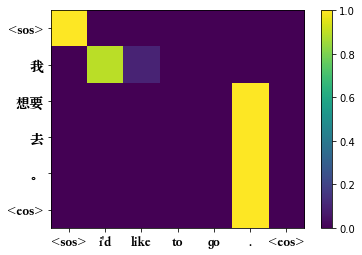

--------------------------
编号为： 14494
原文为：my car cost more than yours did . 
标准答案为：我的车子的开销比你的要多。
预测答案为：我的车子的你你你你。。


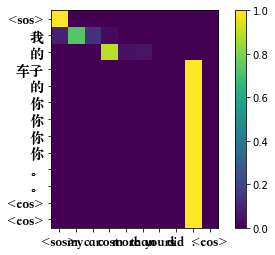

--------------------------
编号为： 11554
原文为：he is able to play the guitar . 
标准答案为：他會彈吉他。
预测答案为：他會彈吉他。


/home/renhongjie/miniconda3/envs/rencaiji/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26371 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/renhongjie/miniconda3/envs/rencaiji/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 24392 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/renhongjie/miniconda3/envs/rencaiji/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 26371 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/renhongjie/miniconda3/envs/rencaiji/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 24392 missing from current font.
  font.set_text(s, 0, flags=flags)


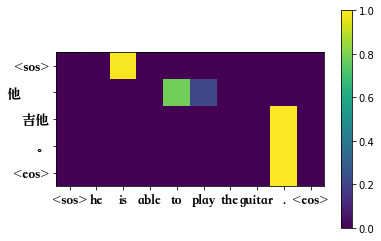

--------------------------
编号为： 15450
原文为：i speak french every day at work . 
标准答案为：我每天工作时都讲法语。
预测答案为：我每天时时都工作。


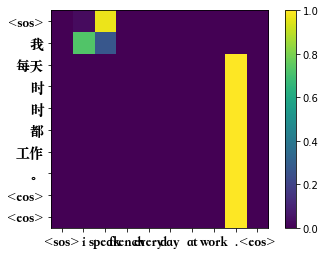

--------------------------
编号为： 23993
原文为：for the time being , my sister is an assistant in a supermarket . 
标准答案为：目前，我妹妹在一家超市当收银员。
预测答案为：這是看见的时候我我。


/home/renhongjie/miniconda3/envs/rencaiji/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 36889 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/renhongjie/miniconda3/envs/rencaiji/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 36889 missing from current font.
  font.set_text(s, 0, flags=flags)


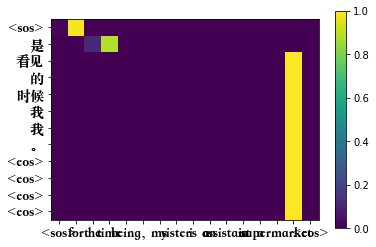

--------------------------
编号为： 10764
原文为：i cut a branch from the tree . 
标准答案为：我從樹上砍下了一根樹枝。
预测答案为：我從樹我我下了樹枝。


/home/renhongjie/miniconda3/envs/rencaiji/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 24478 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/renhongjie/miniconda3/envs/rencaiji/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 27193 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/renhongjie/miniconda3/envs/rencaiji/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 24478 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/renhongjie/miniconda3/envs/rencaiji/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 27193 missing from current font.
  font.set_text(s, 0, flags=flags)


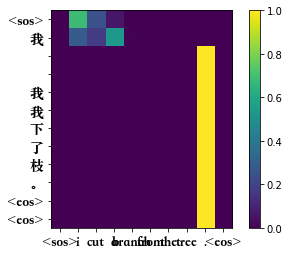

--------------------------
编号为： 3672
原文为：this car sells well . 
标准答案为：这辆车卖得好。
预测答案为：这辆味道得好。


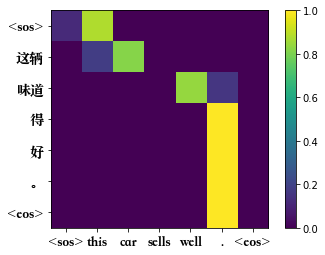

--------------------------
编号为： 17228
原文为：drunk driving is a serious problem . 
标准答案为：酒驾是个严重的问题。
预测答案为：这是是个高的。


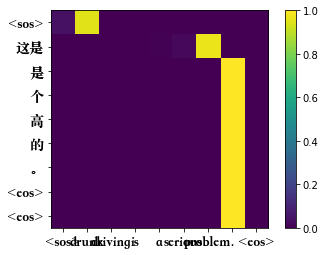

--------------------------
编号为： 930
原文为：you are drunk ! 
标准答案为：你喝醉了！
预测答案为：你喝醉了！！


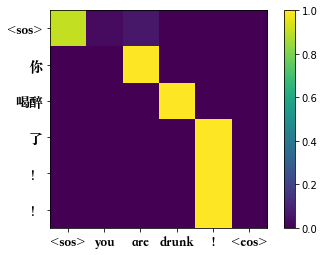

--------------------------
编号为： 1109
原文为：it's not funny . 
标准答案为：这不好笑。
预测答案为：这不是的。


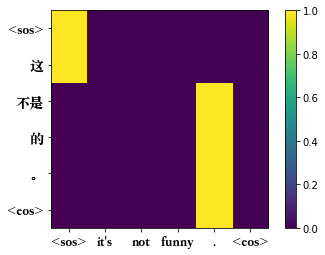

--------------------------


In [83]:
import random
#random.seed(20)
for i in random.sample(range(len(en_data_id)), 10):  # 随机看10个
    print('编号为：',i)
    src=torch.tensor(en_data_id[i]).reshape(-1, 1).to(device)
    tag=torch.tensor(zh_data_id[i]).reshape(-1, 1).to(device)

    src_length=[en_data_id[i].index(2)+1]
    tag_length=[zh_data_id[i].index(2)+1]
    
    output,att = model(src, tag,src_length,tag_length,teacher_forcing_ratio=0)
    src=src.squeeze(1)
    tag=tag.squeeze(1)
    output = output.squeeze(1).argmax(1)
    print('原文为：',end='')
    for j in ((src)):
        if j==1:
            continue
        if j==2:
            break
        k=idx_to_word_en[j.item()]
        print(k,end=' ')
    print()
    print('标准答案为：',end='')
    for j in ((tag)):
        if j==1:
            continue
        if j==2:
            break
        k=idx_to_word_zh[j.item()]
        print(k,end='')
    print()
    print('预测答案为：',end='')
    for j in ((output)):
        if j==1:
            continue
        if j==2:
            break
        k=idx_to_word_zh[j.item()]
        print(k,end='')
    print()
    att_show(src,output,att)
    print('--------------------------')